# Word-by-word local coherence simulations

This is a first attempt at a word-by-word SOSP model of local coherence effects. To start with, I'm just simulating the string *at the player tossed/thrown* to keep the system small.

The LCLexicon.yaml file stores the lexical entries. In these simulations, there are four lexical features, noun, preposition, main verb, and participle. The head features on all words are what you would expect: one-hot vectors with the relevant feature turned on. The dependent attachment sites are:

- *at*: PObj (object of a preposition, noun)
- *player*: RCmod (relative clause modifier, participle)
- *thrown*: no dependents
- *tossed* (main verb): Subj (noun)
- *tossed* (participle): no dependents

This should produce the desired effect (i.e., longer processing times at the participle) because *tossed* is ambiguous, with local harmonies of the structures being different, while *thrown* is unambiguous.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # additional plotting tools
# the word-by-word system; there's also a simpler interface for running the smaller models we've done before
import sosp.incremental as inc

In [2]:
file = './LCLexicon.yaml'
sent_len = 3  # at player tossed
# Only considering these strings
corp = [['at', 'player', 'tossed'], ['at', 'player', 'thrown']]

The next cell creates the system. We specify the file with the lexicon, the names of the lexical features, the maximum sentence length, and the corpus. The `missing_link_cost` is the penalty for having fewer than the maximum possible number of links for a string of words. The harmony (calculated as in Smith & Tabor, 2018) is multiplied by this value as many times as there are missing links. Gamma is the width parameter for the RBFs. The stopping criterion `cheb_stop` uses the Chebyshev distance to attractors as the stopping criterion. The system continues processing a word until the maximum distance on any dimension of the state vector drops below the default tolerance of 0.5. The parameters here were chosen arbitrarily, but they seem to work well.

Initializing the model sets up the basic processing system, arranging and naming all of the dimensions of the state vector.

In [3]:
# Creating the system
sys = inc.Struct(lex_file=file, features=['N', 'Prep', 'MainVerb', 'Participle'],
                 max_sent_length=sent_len, missing_link_cost=0.1, gamma=0.45,
                 stopping_crit='cheb_stop', corpus=corp)

Naming position dimensions...
Naming links...


The next cell generates all of the centers for use with the RBFs and calculates the local harmonies $h_i$ of each one. Because very low-harmony peaks can be absorbed into higher harmony peaks, I also use a numerical optimizer (the L-BFGS-B algorithm) to find all of the actual maxima of the harmony function. These are used for testing whether the system has processed a word long enough.

In [4]:
sys.gen_centers()
sys.calculate_local_harmonies()
sys.locate_attrs()

Naming links...
Naming links...
Number of centers generated: 32
Found 30 unique attractors from 32 centers


We're now ready to do some test runs, first with the control (*thrown*) condition.

In [5]:
sys.set_params(noise_mag=0.0005)  # Setting the noise to be a bit larger in magnitude than the default 0.0001
final, data = sys.single_run(corp[1])  # Do a single run with the "thrown" condition
# Returns the state vector at the last time step and basic word-by-word data.

/Users/garrettsmith/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


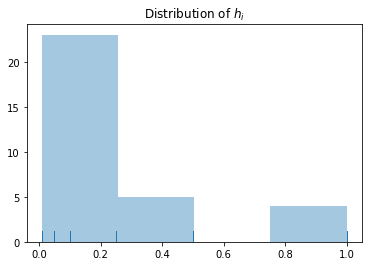

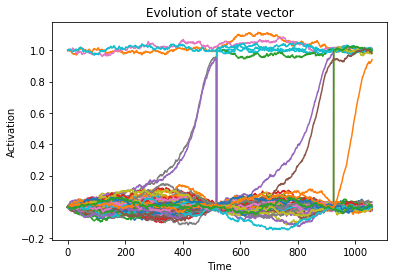

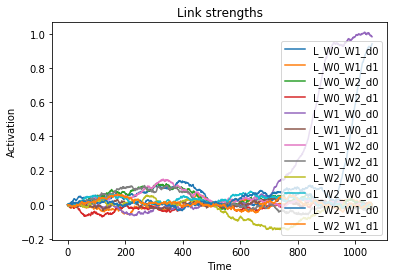

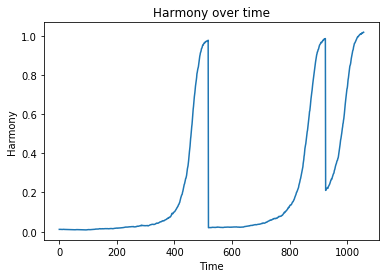

Active dimensions at the end of processing:
 ['W0_at', 'W0_Prep', 'W0_d0_N', 'W1_player', 'W1_N', 'W1_d0_Participle', 'W2_thrown', 'W2_Participle', 'L_W1_W0_d0', 'L_W2_W1_d0'] 

Basic data output: word number, word, processing time
 [[0, 'at', 517], [1, 'player', 406], [2, 'thrown', 133]] 



In [6]:
# Plotting
sns.distplot(sys.local_harmonies, kde=False, rug=True)
plt.title('Distribution of $h_i$')
plt.show()
sys.plot_trace()  # The whole state vector over time
sys.plot_links()  # Just the links
sys.plot_harmony()  # Harmony over time
print('Active dimensions at the end of processing:\n', sys.which_nonzero(np.round(final)), '\n')
print('Basic data output: word number, word, processing time\n', data, '\n')

Unsurprisingly, the system processed this string correctly. At the end of processing, all of the correct dimensions are active, and the words are correctly linked; `L_W1_W0_d0` means that word 1 (*player*) is linked to word 0's (*at*) 0th dependent attachment site (PObj), and `L_W2_W1_d0` means the participle is attached as *player*'s RCmod dependent.

Now, let's try a single run of the *tossed* condition.

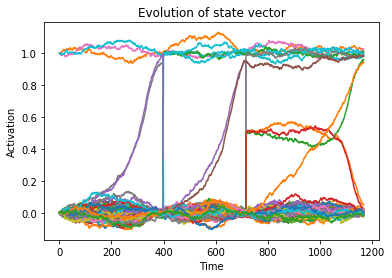

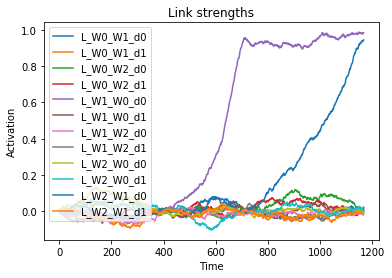

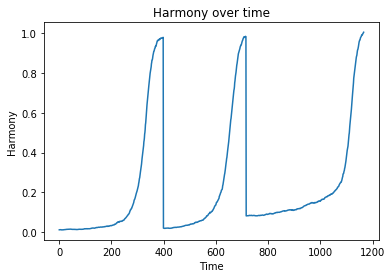

Active dimensions at the end of processing:
 ['W0_at', 'W0_Prep', 'W0_d0_N', 'W1_player', 'W1_N', 'W1_d0_Participle', 'W2_tossed', 'W2_Participle', 'L_W1_W0_d0', 'L_W2_W1_d0'] 

Basic data output: word number, word, processing time
 [[0, 'at', 398], [1, 'player', 316], [2, 'tossed', 451]] 



In [7]:
final2, data2 = sys.single_run(corp[0])
sys.plot_trace()
sys.plot_links()
sys.plot_harmony()
print('Active dimensions at the end of processing:\n', sys.which_nonzero(np.round(final2)), '\n')
print('Basic data output: word number, word, processing time\n', data2, '\n')

The system correctly parsed this condition in this case, too. *Tossed* attached as the RCmod dependent of *player*, which attached as the PObj of *at*. The processing time at *tossed* is considerably longer than *thrown*, though.

We now run multiple runs in each condition. 

In [8]:
print('Running control...')
ctl = sys.many_runs(100, corp[1])  # 100 runs using the "thrown" condition"
print('\nRunning local coherence condition...')
lc = sys.many_runs(100, corp[0])  # 100 runs with "tossed"

Running control...
Run number:
[0] [10] [20] [30] [40] [50] [60] [70] [80] [90] 
Running local coherence condition...
Run number:
[0] [10] [20] [30] [40] [50] [60] [70] [80] [90] 

In [9]:
print('Control summary:\n------------')
print(ctl.groupby('WordNr').agg({'WordRT': ['mean', 'std', 'max']}))
print('\n\nLocal coherence summary:\n------------')
print(lc.groupby('WordNr').agg({'WordRT': ['mean', 'std', 'max']}))

Control summary:
------------
        WordRT                
          mean        std  max
WordNr                        
0       410.24  53.561278  572
1       358.23  47.050554  502
2       127.13   6.199796  143


Local coherence summary:
------------
        WordRT                
          mean        std  max
WordNr                        
0       413.66  62.253347  678
1       359.08  38.753216  451
2       347.73  92.055742  633


On average, the two conditions produce comparable processing times for *at* and *player*, but they diverge at the participle, with *tossed* taking longer than *thrown*.

The next cell presents the mean processing times by the attractor that the system picked, then the cells after that aggregate the data and display the active dimensions for each of those attractors.

In [13]:
print(ctl[ctl['WordNr'] == 2].groupby('FinalCenterNr').agg({'WordRT': ['mean', 'std', 'min', 'max', 'count']}))
print(lc[lc['WordNr'] == 2].groupby('FinalCenterNr').agg({'WordRT': ['mean', 'std', 'min', 'max','count']}))

               WordRT                          
                 mean       std  min  max count
FinalCenterNr                                  
5              127.13  6.199796  114  143   100
                   WordRT                           
                     mean        std  min  max count
FinalCenterNr                                       
15             512.894737  50.866814  435  633    19
26             308.987654  43.659333  244  445    81


In [11]:
import pandas as pd
ctl['Cond'] = 'ctl'
lc['Cond'] = 'lc'
full_data = pd.concat([ctl, lc], ignore_index=True)

In [12]:
for c in full_data.FinalCenterNr.unique():
    print('Attractor {0:02d}'.format(c) ,sys.which_nonzero(sys.centers[c,]), '\n')

Attractor 05 ['W0_at', 'W0_Prep', 'W0_d0_N', 'W1_player', 'W1_N', 'W1_d0_Participle', 'W2_thrown', 'W2_Participle', 'L_W1_W0_d0', 'L_W2_W1_d0'] 

Attractor 26 ['W0_at', 'W0_Prep', 'W0_d0_N', 'W1_player', 'W1_N', 'W1_d0_Participle', 'W2_tossed', 'W2_Participle', 'L_W1_W0_d0', 'L_W2_W1_d0'] 

Attractor 15 ['W0_at', 'W0_Prep', 'W0_d0_N', 'W1_player', 'W1_N', 'W1_d0_Participle', 'W2_tossed', 'W2_MainVerb', 'W2_d0_N', 'L_W1_W0_d0', 'L_W2_W1_d0'] 



The *thrown* condition only approaches the grammatical attractor, as expected. *Tossed* takes longer for both attractors that it approaches, but those attractors are not quite what we would expect. In both cases, *tossed* attaches as *player*'s RCmod; what differs is the part of speech *tossed* assumes. Sometimes it's a main verb and sometimes it's a participle.

Maybe the simplest structure that accords with our intuitions about what makes this sequence locally coherent would be that the erroneous parse should leave *at* floating unattached and *player* attached as the subject of the main verb *tossed*. This structure is unlikely to form in the current system, though, because it would mean undoing the already-formed *at-player* link after hearing *tossed*. The erroneous attractor it does approach has low harmony, but it involves less change to the already established structure and so forms more easily.

Below is a figure showing the effect from the tables above.

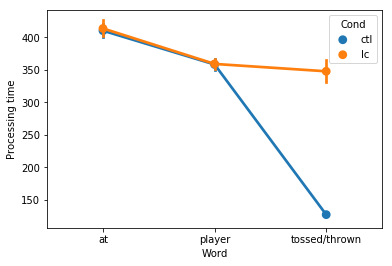

In [15]:
fig = sns.pointplot(x='WordNr', y='WordRT', hue='Cond', data=full_data)
fig.set_xticklabels(['at', 'player', 'tossed/thrown'])
plt.xlabel('Word')
plt.ylabel('Processing time')
plt.show()

The question now is whether we think the model is a good model of what people do. In the model, the processing cost of locally coherent structures (in this case, at least) amount to a part of speech ambiguity, not trouble building the correct syntactic structure. I think this makes sense, but it differs from how people usually talk about local coherence (with the possible exception of Bicknell, Levy, and Demberg, 2009). 